In this example, we will go through one possible use of the `nasapy` library by extracting a decade of fireball data from the [NASA API](https://api.nasa.gov/) and visualizing it on a map.

A fireball, as defined by the [Center for Near Earth Object Studies (CNEOS)](https://cneos.jpl.nasa.gov/fireballs/intro.html), is: 

> A fireball is an unusually bright meteor that reaches a visual magnitude of -3 or brighter when seen at the observer’s zenith. Objects causing fireball events can exceed one meter in size. Fireballs that explode in the atmosphere are technically referred to as bolides, although the terms fireballs and bolides are often used interchangeably.

> During the atmospheric entry phase, an impacting object is both slowed and heated by atmospheric friction. In front of it, a bow shock develops where atmospheric gases are compressed and heated. Some of this energy is radiated to the object causing it to ablate, and in most cases, to break apart. Fragmentation increases the amount of atmosphere intercepted, and so enhances ablation and atmospheric braking. The object catastrophically disrupts when the force from the unequal pressures on the front and back sides exceeds its tensile strength.

Before getting started, import the needed packages that we will be using. The data analysis library [pandas](https://pandas.pydata.org/) will be used to wrangle the data, while [folium](https://python-visualization.github.io/folium/) and [seaborn](https://seaborn.pydata.org/) are used for plotting the data. The magic command [`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/plotting.html#id1) is loaded to display the generated plots.

In [ ]:
import nasapy
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using the [`nasapy`](https://github.com/aschleg/nasapy) library, we can extract the last 10 years of fireball data as a pandas `DataFrame` by calling the `fireballs` function. The `fireballs` method does not require authentication to the NASA API, so we can go straight to getting the data.

In [2]:
fb = nasapy.fireballs(date_min='2010-01-01', date_max='2019-12-31', return_df=True)

Before plotting the data, we will do a few cleanup and pre-processing steps to get the data ready. The first step is to remove any duplicate records from the results using the [`dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method. Afterward, we will convert the necessary data points to a `float` data type to ensure the data is of a sufficient type to plot. This conversion can be accomplished by using the [`astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html) method.

In [3]:
fb.dropna(inplace=True)

fb['lat'] = fb['lat'].astype(float)
fb['lon'] = fb['lon'].astype(float)
fb['energy'] = fb['energy'].astype(float)

Using the [`head`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method, we can inspect the first 5 (by default) rows of the data.

In [4]:
fb.head()

,date,energy,impact-e,lat,lat-dir,lon,lon-dir,alt,vel
0,2010-01-15 19:17:54,49.2,1.2,8.3,S,27.0,E,25.0,14.0
3,2010-02-28 22:24:50,15.3,0.44,48.7,N,21.0,E,37.0,15.1
4,2010-03-08 22:02:07,32.3,0.85,32.0,N,92.9,W,52.0,24.5
10,2010-04-16 04:38:52,84.4,2,1.8,N,176.9,W,22.2,18.8
15,2010-07-06 23:54:43,756.0,14,34.1,S,174.5,W,26.0,15.7


The `energy` and `impact-e` are specified in [Joules](https://en.wikipedia.org/wiki/Joule), which is a unit of energy defined as kilograms times velocity squared, `kg * (m/s)^2`.

We are now ready to plot the data! The `folium` map that will be displayed is initialized using the [`folium`](https://python-visualization.github.io/folium/) `Map` object, and then for each data point in the extracted and processed data from earlier, we add a point to the map with the data we are interested in displaying.

In [5]:
m = folium.Map(zoom_start=4)

for i in range(0, len(fb)):
    
    folium.Circle(
        location=[fb.iloc[i]['lat'], fb.iloc[i]['lon']],
        tooltip=['Date: ' + fb.iloc[i]['date'], 
                 '\nLat/Lon: ' + str(fb.iloc[i]['lat']) + ', ' + str(fb.iloc[i]['lon'])],
        radius=fb.iloc[i]['energy'] * 10,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)
m

Interestingly, it seems two fireball events are much larger than the others. Let's investigate further by plotting the energy values of the fireballs using the [`seaborn`](https://seaborn.pydata.org/) library. First, we will extract the date from the `datetime` column in the data and sort the data ascending by energy value to prepare it for plotting.

In [6]:
fb['datetime'] = fb['date']
fb['date'] = fb['datetime'].apply(lambda x: x.split(' ')[0])

fb.sort_values('energy', ascending=False, inplace=True)

With the data prepped accordingly, we can use the seaborn [`barplot`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function to plot the fireball energy values by date.

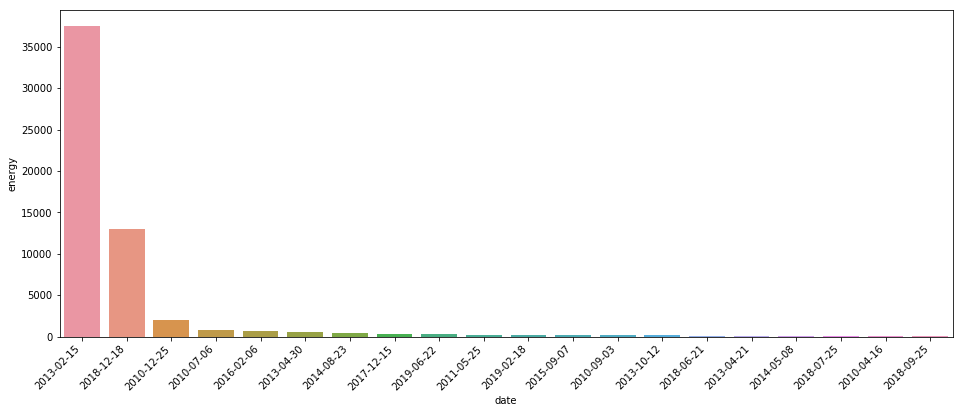

In [7]:
plt.figure(figsize=(16, 6))
p = sns.barplot(x='date', y='energy', data=fb[0:20])
p = p.set_xticklabels(fb['date'], rotation=45, ha='right')

As we suspected, two fireballs had much higher energy values than others! The highest energy value is almost two times as much as the next fireball, which itself is many times more powerful than the next. To get a better representation of the overall data, let's cut these points out and plot the points on a map again.

In [8]:
fb2 = fb[fb['energy'] < 5000]

m = folium.Map(zoom_start=0.1)

for i in range(0, len(fb2)):
    
    folium.Circle(
        location=[fb2.iloc[i]['lat'], fb2.iloc[i]['lon']],
        tooltip=['Date: ' + fb2.iloc[i]['date'], 
                 '\nLat/Lon: ' + str(fb2.iloc[i]['lat']) + ', ' + str(fb2.iloc[i]['lon'])],
        radius=fb2.iloc[i]['energy'] * 100,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)
m